### Compare the performance of CNN, CNN with batch norm versus fully connected Neural net 

In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
#defining common parameters and visualization function

batch_size = 64
n_epochs = 20
print_every = 300


In [3]:
#setting up transforming of the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#loading train and val sets
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


{'0 - zero': 0, '7 - seven': 7, '6 - six': 6, '1 - one': 1, '3 - three': 3, '5 - five': 5, '9 - nine': 9, '2 - two': 2, '8 - eight': 8, '4 - four': 4}


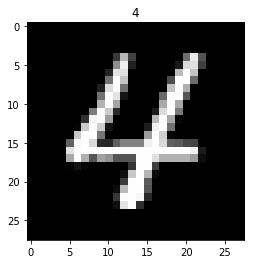

In [4]:
img, lab = next(iter(trainloader))
fig, ax = plt.subplots()
ax.imshow(np.squeeze(img[0].numpy()), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
ax.set_title(str(lab[0].item()))
print(trainset.class_to_idx)

In [5]:
#create a fully connected layer
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        super(MLP, self).__init__()
        
        #first layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        #intermediate layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for (h1, h2) in layer_sizes])
        
        #output layer
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        #droput
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        #looping through hidden layers
        x = x.view(x.shape[0], -1)
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        
        #final layer
        x = self.output(x)
        
        #softmax for multi output classifications
        x = F.log_softmax(x, dim=1)
        
        return x
        
        

In [6]:
#image size after Convolution = (size_before - kernel_size + 2*padding) // stride + 1 
def conv(in_channels, out_channels, kernel_size, stride, padding=1, batch_norm=True, maxpool=True):
    layers=[]
    
    conv_layers = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                           stride=stride, padding=padding, bias = (not batch_norm))
    layers.append(conv_layers)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    #if maxpool: #onlyu sue maxpool for large images, to adapt this size stride / use
    #    layers.append(nn.MaxPool2d(2,2))
    
    return nn.Sequential(*layers)

In [7]:
#create a CNN/maxpooling where depths increase by 2 for each convolution starting from a given conv_dims_base
#we assume a square image
class CNN(nn.Module):
    def __init__(self,  conv_dims_base, conv_depth, image_size, output_size, bact_norm=False, drop_p=0.5):
        super(CNN, self).__init__()
        
        #first convolutio
        self.conv_layers = nn.ModuleList([conv(1, conv_dims_base, kernel_size=3, stride=2, batch_norm=bact_norm)])  
        self.image_size = int(image_size / 2)
        
        if conv_depth>1:
            self.conv_layers.extend([conv(conv_dims_base * 2**(i-1), conv_dims_base * 2**i,
                                          kernel_size=3, stride=2, batch_norm=bact_norm) for i in np.arange(1, conv_depth)])
            self.image_size = int(self.image_size /  2 **(conv_depth-1))
        
        self.fc1 = nn.Linear(self.image_size*self.image_size * conv_dims_base * 2**(conv_depth-1), 2*output_size)
        self.fc2 = nn.Linear(2*output_size, output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):

        for each in self.conv_layers:
            x = F.relu(each(x))
    
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x


In [8]:
def complexity_parameters(neural_net):
    #Computing the numbers of parameters involved for a given neural net
    param_count=0
    
    for i in neural_net.state_dict().values():
        dim_i = list(i.shape)
        param_count += np.prod(dim_i)
    
    return int(param_count)

In [9]:
mlp = MLP(28*28, 10, [64,128])
print(complexity_parameters(mlp))

cnn = CNN(16, 2, 28, 10)
print(complexity_parameters(cnn))

cnn_batch = CNN(16, 2, 28, 10, bact_norm=True)
print(complexity_parameters(cnn_batch))

59850
36390
36536


### Due to its easier calibration, we allow the mlp to have much more parameters than the CNN
Let's train them now

In [10]:
criterion = nn.NLLLoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)
optimizer_cnn_batch = optim.Adam(cnn_batch.parameters(), lr=0.001)

### Let's do the training

In [11]:
def training(model, optimizer, criterion, trainloader, testloader, n_epochs, save_path, need_eval=False, print_every=100):
    if need_eval:
        model.train()
        
    test_loss_min = np.Inf 
    list_train_loss, list_test_loss, list_accuracy = [], [], []
    
    for e in tqdm(range(n_epochs)):
        
        train_loss = 0
        test_loss = 0
        accuracy = 0
        n_batch = len(trainloader)
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += 1/(batch_idx+1) * (loss.item() - train_loss)
            
            if (batch_idx + 1) %print_every == 0 or batch_idx == n_batch-1:
                print("Current Epoch: {}/{}, Current Progress: {}/{}, Train Loss: {:.6f}".format(e+1, n_epochs, batch_idx+1, 
                                                                                               n_batch, train_loss))
        ######################    
        # validate the model #
        ######################
        if need_eval:
            model.eval()
        for inputs, labels in testloader:
            with torch.no_grad():
                outputs = model(inputs)
                
                ps = torch.exp(outputs)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class==labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
        test_loss /= len(testloader)
        accuracy /= len(testloader)
        if need_eval:
            model.train()
        
        print("Current Epoch: {}/{}, Test Loss: {:.6f}, Test Accuracy: {:.3f} %".format(e+1, n_epochs, 
                                                                                        test_loss, 100*accuracy))
        
        if test_loss < test_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(test_loss_min, test_loss))
            torch.save(model.state_dict(), save_path)
            test_loss_min = test_loss
        
        
        
        list_train_loss += [train_loss]
        list_test_loss += [test_loss]
        list_accuracy += [accuracy]

        
    return [list_train_loss, list_test_loss, list_accuracy]

In [12]:
mlp_metrics = training(mlp, optimizer_mlp, criterion, trainloader, testloader, n_epochs=n_epochs, 
                                         save_path="trained_models\mlp.pt",need_eval=True, print_every=print_every)
cnn_metrics = training(cnn, optimizer_cnn, criterion, trainloader, testloader, n_epochs=n_epochs, 
                                         save_path="trained_models\cnn.pt",need_eval=False, print_every=print_every)
cnn_batch_metrics = training(cnn_batch, optimizer_cnn_batch, criterion, trainloader, testloader, n_epochs=n_epochs, 
                                         save_path="trained_models\cnn_batch.pt",need_eval=True, print_every=print_every)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Current Epoch: 1/20, Current Progress: 300/938, Train Loss: 1.223319
Current Epoch: 1/20, Current Progress: 600/938, Train Loss: 0.995227
Current Epoch: 1/20, Current Progress: 900/938, Train Loss: 0.888688
Current Epoch: 1/20, Current Progress: 938/938, Train Loss: 0.879623


  5%|████▏                                                                              | 1/20 [00:36<11:37, 36.72s/it]

Current Epoch: 1/20, Test Loss: 0.321123, Test Accuracy: 90.665 %
Validation loss decreased (inf --> 0.321123). Saving model ...
Current Epoch: 2/20, Current Progress: 300/938, Train Loss: 0.635599
Current Epoch: 2/20, Current Progress: 600/938, Train Loss: 0.627039
Current Epoch: 2/20, Current Progress: 900/938, Train Loss: 0.613356
Current Epoch: 2/20, Current Progress: 938/938, Train Loss: 0.612020


 10%|████████▎                                                                          | 2/20 [01:13<10:59, 36.65s/it]

Current Epoch: 2/20, Test Loss: 0.285086, Test Accuracy: 91.799 %
Validation loss decreased (0.321123 --> 0.285086). Saving model ...
Current Epoch: 3/20, Current Progress: 300/938, Train Loss: 0.564417
Current Epoch: 3/20, Current Progress: 600/938, Train Loss: 0.562929
Current Epoch: 3/20, Current Progress: 900/938, Train Loss: 0.555726
Current Epoch: 3/20, Current Progress: 938/938, Train Loss: 0.555671


 15%|████████████▍                                                                      | 3/20 [01:50<10:27, 36.89s/it]

Current Epoch: 3/20, Test Loss: 0.261885, Test Accuracy: 92.287 %
Validation loss decreased (0.285086 --> 0.261885). Saving model ...
Current Epoch: 4/20, Current Progress: 300/938, Train Loss: 0.550102
Current Epoch: 4/20, Current Progress: 600/938, Train Loss: 0.543551
Current Epoch: 4/20, Current Progress: 900/938, Train Loss: 0.538370
Current Epoch: 4/20, Current Progress: 938/938, Train Loss: 0.538640


 20%|████████████████▌                                                                  | 4/20 [02:27<09:47, 36.75s/it]

Current Epoch: 4/20, Test Loss: 0.261495, Test Accuracy: 92.217 %
Validation loss decreased (0.261885 --> 0.261495). Saving model ...
Current Epoch: 5/20, Current Progress: 300/938, Train Loss: 0.510922
Current Epoch: 5/20, Current Progress: 600/938, Train Loss: 0.518740
Current Epoch: 5/20, Current Progress: 900/938, Train Loss: 0.515242
Current Epoch: 5/20, Current Progress: 938/938, Train Loss: 0.514748


 25%|████████████████████▊                                                              | 5/20 [03:06<09:23, 37.56s/it]

Current Epoch: 5/20, Test Loss: 0.254107, Test Accuracy: 92.685 %
Validation loss decreased (0.261495 --> 0.254107). Saving model ...
Current Epoch: 6/20, Current Progress: 300/938, Train Loss: 0.507098
Current Epoch: 6/20, Current Progress: 600/938, Train Loss: 0.502654
Current Epoch: 6/20, Current Progress: 900/938, Train Loss: 0.503347
Current Epoch: 6/20, Current Progress: 938/938, Train Loss: 0.501555


 30%|████████████████████████▉                                                          | 6/20 [03:37<08:16, 35.46s/it]

Current Epoch: 6/20, Test Loss: 0.229314, Test Accuracy: 93.143 %
Validation loss decreased (0.254107 --> 0.229314). Saving model ...
Current Epoch: 7/20, Current Progress: 300/938, Train Loss: 0.489477
Current Epoch: 7/20, Current Progress: 600/938, Train Loss: 0.484809
Current Epoch: 7/20, Current Progress: 900/938, Train Loss: 0.490956
Current Epoch: 7/20, Current Progress: 938/938, Train Loss: 0.490408


 35%|█████████████████████████████                                                      | 7/20 [03:54<06:30, 30.01s/it]

Current Epoch: 7/20, Test Loss: 0.225592, Test Accuracy: 93.213 %
Validation loss decreased (0.229314 --> 0.225592). Saving model ...
Current Epoch: 8/20, Current Progress: 300/938, Train Loss: 0.494694
Current Epoch: 8/20, Current Progress: 600/938, Train Loss: 0.491821
Current Epoch: 8/20, Current Progress: 900/938, Train Loss: 0.490755
Current Epoch: 8/20, Current Progress: 938/938, Train Loss: 0.490067


 40%|█████████████████████████████████▏                                                 | 8/20 [04:14<05:24, 27.06s/it]

Current Epoch: 8/20, Test Loss: 0.217903, Test Accuracy: 93.521 %
Validation loss decreased (0.225592 --> 0.217903). Saving model ...
Current Epoch: 9/20, Current Progress: 300/938, Train Loss: 0.486022
Current Epoch: 9/20, Current Progress: 600/938, Train Loss: 0.481967
Current Epoch: 9/20, Current Progress: 900/938, Train Loss: 0.477968
Current Epoch: 9/20, Current Progress: 938/938, Train Loss: 0.476371


 45%|█████████████████████████████████████▎                                             | 9/20 [04:34<04:35, 25.00s/it]

Current Epoch: 9/20, Test Loss: 0.220641, Test Accuracy: 93.521 %
Current Epoch: 10/20, Current Progress: 300/938, Train Loss: 0.466302
Current Epoch: 10/20, Current Progress: 600/938, Train Loss: 0.474151
Current Epoch: 10/20, Current Progress: 900/938, Train Loss: 0.471374
Current Epoch: 10/20, Current Progress: 938/938, Train Loss: 0.472771


 50%|█████████████████████████████████████████                                         | 10/20 [04:53<03:51, 23.11s/it]

Current Epoch: 10/20, Test Loss: 0.226804, Test Accuracy: 93.451 %
Current Epoch: 11/20, Current Progress: 300/938, Train Loss: 0.471167
Current Epoch: 11/20, Current Progress: 600/938, Train Loss: 0.468201
Current Epoch: 11/20, Current Progress: 900/938, Train Loss: 0.468076
Current Epoch: 11/20, Current Progress: 938/938, Train Loss: 0.469112


 55%|█████████████████████████████████████████████                                     | 11/20 [05:12<03:16, 21.78s/it]

Current Epoch: 11/20, Test Loss: 0.237247, Test Accuracy: 93.213 %
Current Epoch: 12/20, Current Progress: 300/938, Train Loss: 0.454037
Current Epoch: 12/20, Current Progress: 600/938, Train Loss: 0.452264
Current Epoch: 12/20, Current Progress: 900/938, Train Loss: 0.457909
Current Epoch: 12/20, Current Progress: 938/938, Train Loss: 0.458768


 60%|█████████████████████████████████████████████████▏                                | 12/20 [05:30<02:46, 20.81s/it]

Current Epoch: 12/20, Test Loss: 0.223067, Test Accuracy: 93.292 %
Current Epoch: 13/20, Current Progress: 300/938, Train Loss: 0.460683
Current Epoch: 13/20, Current Progress: 600/938, Train Loss: 0.462640
Current Epoch: 13/20, Current Progress: 900/938, Train Loss: 0.461018
Current Epoch: 13/20, Current Progress: 938/938, Train Loss: 0.461275


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [05:49<02:20, 20.10s/it]

Current Epoch: 13/20, Test Loss: 0.235190, Test Accuracy: 93.521 %
Current Epoch: 14/20, Current Progress: 300/938, Train Loss: 0.438994
Current Epoch: 14/20, Current Progress: 600/938, Train Loss: 0.447938
Current Epoch: 14/20, Current Progress: 900/938, Train Loss: 0.448534
Current Epoch: 14/20, Current Progress: 938/938, Train Loss: 0.450307


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [06:07<01:57, 19.62s/it]

Current Epoch: 14/20, Test Loss: 0.225687, Test Accuracy: 93.850 %
Current Epoch: 15/20, Current Progress: 300/938, Train Loss: 0.463809
Current Epoch: 15/20, Current Progress: 600/938, Train Loss: 0.456669
Current Epoch: 15/20, Current Progress: 900/938, Train Loss: 0.459273
Current Epoch: 15/20, Current Progress: 938/938, Train Loss: 0.459313


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [06:26<01:36, 19.32s/it]

Current Epoch: 15/20, Test Loss: 0.215109, Test Accuracy: 93.740 %
Validation loss decreased (0.217903 --> 0.215109). Saving model ...
Current Epoch: 16/20, Current Progress: 300/938, Train Loss: 0.454160
Current Epoch: 16/20, Current Progress: 600/938, Train Loss: 0.449019
Current Epoch: 16/20, Current Progress: 900/938, Train Loss: 0.449804
Current Epoch: 16/20, Current Progress: 938/938, Train Loss: 0.449722


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [06:44<01:16, 19.06s/it]

Current Epoch: 16/20, Test Loss: 0.211530, Test Accuracy: 94.088 %
Validation loss decreased (0.215109 --> 0.211530). Saving model ...
Current Epoch: 17/20, Current Progress: 300/938, Train Loss: 0.446332
Current Epoch: 17/20, Current Progress: 600/938, Train Loss: 0.446938
Current Epoch: 17/20, Current Progress: 900/938, Train Loss: 0.443060
Current Epoch: 17/20, Current Progress: 938/938, Train Loss: 0.444404


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [07:03<00:56, 18.91s/it]

Current Epoch: 17/20, Test Loss: 0.212322, Test Accuracy: 93.979 %
Current Epoch: 18/20, Current Progress: 300/938, Train Loss: 0.445953
Current Epoch: 18/20, Current Progress: 600/938, Train Loss: 0.444131
Current Epoch: 18/20, Current Progress: 900/938, Train Loss: 0.444403
Current Epoch: 18/20, Current Progress: 938/938, Train Loss: 0.443130


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [07:22<00:37, 18.91s/it]

Current Epoch: 18/20, Test Loss: 0.208811, Test Accuracy: 93.710 %
Validation loss decreased (0.211530 --> 0.208811). Saving model ...
Current Epoch: 19/20, Current Progress: 300/938, Train Loss: 0.434231
Current Epoch: 19/20, Current Progress: 600/938, Train Loss: 0.436828
Current Epoch: 19/20, Current Progress: 900/938, Train Loss: 0.436769
Current Epoch: 19/20, Current Progress: 938/938, Train Loss: 0.437860


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:40<00:18, 18.78s/it]

Current Epoch: 19/20, Test Loss: 0.218882, Test Accuracy: 93.720 %
Current Epoch: 20/20, Current Progress: 300/938, Train Loss: 0.445604
Current Epoch: 20/20, Current Progress: 600/938, Train Loss: 0.438165
Current Epoch: 20/20, Current Progress: 900/938, Train Loss: 0.437991
Current Epoch: 20/20, Current Progress: 938/938, Train Loss: 0.438172


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Current Epoch: 20/20, Test Loss: 0.212502, Test Accuracy: 93.840 %
Current Epoch: 1/20, Current Progress: 300/938, Train Loss: 1.594008
Current Epoch: 1/20, Current Progress: 600/938, Train Loss: 1.370934
Current Epoch: 1/20, Current Progress: 900/938, Train Loss: 1.243842
Current Epoch: 1/20, Current Progress: 938/938, Train Loss: 1.230872


  5%|████▏                                                                              | 1/20 [00:39<12:21, 39.03s/it]

Current Epoch: 1/20, Test Loss: 0.903775, Test Accuracy: 62.868 %
Validation loss decreased (inf --> 0.903775). Saving model ...
Current Epoch: 2/20, Current Progress: 300/938, Train Loss: 0.866200
Current Epoch: 2/20, Current Progress: 600/938, Train Loss: 0.835759
Current Epoch: 2/20, Current Progress: 900/938, Train Loss: 0.816000
Current Epoch: 2/20, Current Progress: 938/938, Train Loss: 0.814348


 10%|████████▎                                                                          | 2/20 [01:20<11:56, 39.79s/it]

Current Epoch: 2/20, Test Loss: 0.761270, Test Accuracy: 69.964 %
Validation loss decreased (0.903775 --> 0.761270). Saving model ...
Current Epoch: 3/20, Current Progress: 300/938, Train Loss: 0.748792
Current Epoch: 3/20, Current Progress: 600/938, Train Loss: 0.744837
Current Epoch: 3/20, Current Progress: 900/938, Train Loss: 0.735780
Current Epoch: 3/20, Current Progress: 938/938, Train Loss: 0.734174


 15%|████████████▍                                                                      | 3/20 [01:59<11:12, 39.56s/it]

Current Epoch: 3/20, Test Loss: 0.702494, Test Accuracy: 71.099 %
Validation loss decreased (0.761270 --> 0.702494). Saving model ...
Current Epoch: 4/20, Current Progress: 300/938, Train Loss: 0.699223
Current Epoch: 4/20, Current Progress: 600/938, Train Loss: 0.694600
Current Epoch: 4/20, Current Progress: 900/938, Train Loss: 0.695392
Current Epoch: 4/20, Current Progress: 938/938, Train Loss: 0.695314


 20%|████████████████▌                                                                  | 4/20 [02:38<10:29, 39.33s/it]

Current Epoch: 4/20, Test Loss: 0.682005, Test Accuracy: 73.418 %
Validation loss decreased (0.702494 --> 0.682005). Saving model ...
Current Epoch: 5/20, Current Progress: 300/938, Train Loss: 0.670923
Current Epoch: 5/20, Current Progress: 600/938, Train Loss: 0.671847
Current Epoch: 5/20, Current Progress: 900/938, Train Loss: 0.673140
Current Epoch: 5/20, Current Progress: 938/938, Train Loss: 0.673471


 25%|████████████████████▊                                                              | 5/20 [03:16<09:44, 38.99s/it]

Current Epoch: 5/20, Test Loss: 0.681348, Test Accuracy: 74.313 %
Validation loss decreased (0.682005 --> 0.681348). Saving model ...
Current Epoch: 6/20, Current Progress: 300/938, Train Loss: 0.679813
Current Epoch: 6/20, Current Progress: 600/938, Train Loss: 0.673519
Current Epoch: 6/20, Current Progress: 900/938, Train Loss: 0.666030
Current Epoch: 6/20, Current Progress: 938/938, Train Loss: 0.664816


 30%|████████████████████████▉                                                          | 6/20 [03:54<09:02, 38.78s/it]

Current Epoch: 6/20, Test Loss: 0.668935, Test Accuracy: 75.498 %
Validation loss decreased (0.681348 --> 0.668935). Saving model ...
Current Epoch: 7/20, Current Progress: 300/938, Train Loss: 0.644145
Current Epoch: 7/20, Current Progress: 600/938, Train Loss: 0.646058
Current Epoch: 7/20, Current Progress: 900/938, Train Loss: 0.623490
Current Epoch: 7/20, Current Progress: 938/938, Train Loss: 0.620248


 35%|█████████████████████████████                                                      | 7/20 [04:32<08:21, 38.56s/it]

Current Epoch: 7/20, Test Loss: 0.568181, Test Accuracy: 79.240 %
Validation loss decreased (0.668935 --> 0.568181). Saving model ...
Current Epoch: 8/20, Current Progress: 300/938, Train Loss: 0.477606
Current Epoch: 8/20, Current Progress: 600/938, Train Loss: 0.455464
Current Epoch: 8/20, Current Progress: 900/938, Train Loss: 0.441584
Current Epoch: 8/20, Current Progress: 938/938, Train Loss: 0.439354


 40%|█████████████████████████████████▏                                                 | 8/20 [05:11<07:41, 38.45s/it]

Current Epoch: 8/20, Test Loss: 0.414218, Test Accuracy: 85.997 %
Validation loss decreased (0.568181 --> 0.414218). Saving model ...
Current Epoch: 9/20, Current Progress: 300/938, Train Loss: 0.398030
Current Epoch: 9/20, Current Progress: 600/938, Train Loss: 0.392045
Current Epoch: 9/20, Current Progress: 900/938, Train Loss: 0.391983
Current Epoch: 9/20, Current Progress: 938/938, Train Loss: 0.392667


 45%|█████████████████████████████████████▎                                             | 9/20 [05:50<07:04, 38.61s/it]

Current Epoch: 9/20, Test Loss: 0.409816, Test Accuracy: 86.077 %
Validation loss decreased (0.414218 --> 0.409816). Saving model ...
Current Epoch: 10/20, Current Progress: 300/938, Train Loss: 0.374633
Current Epoch: 10/20, Current Progress: 600/938, Train Loss: 0.380728
Current Epoch: 10/20, Current Progress: 900/938, Train Loss: 0.381755
Current Epoch: 10/20, Current Progress: 938/938, Train Loss: 0.381814


 50%|█████████████████████████████████████████                                         | 10/20 [06:29<06:28, 38.88s/it]

Current Epoch: 10/20, Test Loss: 0.378176, Test Accuracy: 87.182 %
Validation loss decreased (0.409816 --> 0.378176). Saving model ...
Current Epoch: 11/20, Current Progress: 300/938, Train Loss: 0.364650
Current Epoch: 11/20, Current Progress: 600/938, Train Loss: 0.360370
Current Epoch: 11/20, Current Progress: 900/938, Train Loss: 0.358492
Current Epoch: 11/20, Current Progress: 938/938, Train Loss: 0.358881


 55%|█████████████████████████████████████████████                                     | 11/20 [07:07<05:47, 38.62s/it]

Current Epoch: 11/20, Test Loss: 0.374477, Test Accuracy: 86.982 %
Validation loss decreased (0.378176 --> 0.374477). Saving model ...
Current Epoch: 12/20, Current Progress: 300/938, Train Loss: 0.343059
Current Epoch: 12/20, Current Progress: 600/938, Train Loss: 0.339537
Current Epoch: 12/20, Current Progress: 900/938, Train Loss: 0.336595
Current Epoch: 12/20, Current Progress: 938/938, Train Loss: 0.336553


 60%|█████████████████████████████████████████████████▏                                | 12/20 [07:46<05:09, 38.67s/it]

Current Epoch: 12/20, Test Loss: 0.357576, Test Accuracy: 87.719 %
Validation loss decreased (0.374477 --> 0.357576). Saving model ...
Current Epoch: 13/20, Current Progress: 300/938, Train Loss: 0.331698
Current Epoch: 13/20, Current Progress: 600/938, Train Loss: 0.329975
Current Epoch: 13/20, Current Progress: 900/938, Train Loss: 0.326989
Current Epoch: 13/20, Current Progress: 938/938, Train Loss: 0.326970


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [08:24<04:30, 38.60s/it]

Current Epoch: 13/20, Test Loss: 0.343610, Test Accuracy: 88.396 %
Validation loss decreased (0.357576 --> 0.343610). Saving model ...
Current Epoch: 14/20, Current Progress: 300/938, Train Loss: 0.319458
Current Epoch: 14/20, Current Progress: 600/938, Train Loss: 0.316198
Current Epoch: 14/20, Current Progress: 900/938, Train Loss: 0.311006
Current Epoch: 14/20, Current Progress: 938/938, Train Loss: 0.311082


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [09:03<03:51, 38.58s/it]

Current Epoch: 14/20, Test Loss: 0.333116, Test Accuracy: 88.455 %
Validation loss decreased (0.343610 --> 0.333116). Saving model ...
Current Epoch: 15/20, Current Progress: 300/938, Train Loss: 0.306402
Current Epoch: 15/20, Current Progress: 600/938, Train Loss: 0.309732
Current Epoch: 15/20, Current Progress: 900/938, Train Loss: 0.309757
Current Epoch: 15/20, Current Progress: 938/938, Train Loss: 0.309116


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [09:42<03:13, 38.65s/it]

Current Epoch: 15/20, Test Loss: 0.317613, Test Accuracy: 89.102 %
Validation loss decreased (0.333116 --> 0.317613). Saving model ...
Current Epoch: 16/20, Current Progress: 300/938, Train Loss: 0.307509
Current Epoch: 16/20, Current Progress: 600/938, Train Loss: 0.300396
Current Epoch: 16/20, Current Progress: 900/938, Train Loss: 0.299783
Current Epoch: 16/20, Current Progress: 938/938, Train Loss: 0.300046


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [10:21<02:34, 38.70s/it]

Current Epoch: 16/20, Test Loss: 0.331659, Test Accuracy: 89.003 %
Current Epoch: 17/20, Current Progress: 300/938, Train Loss: 0.296776
Current Epoch: 17/20, Current Progress: 600/938, Train Loss: 0.297385
Current Epoch: 17/20, Current Progress: 900/938, Train Loss: 0.297380
Current Epoch: 17/20, Current Progress: 938/938, Train Loss: 0.297337


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [10:59<01:55, 38.49s/it]

Current Epoch: 17/20, Test Loss: 0.335682, Test Accuracy: 88.744 %
Current Epoch: 18/20, Current Progress: 300/938, Train Loss: 0.283604
Current Epoch: 18/20, Current Progress: 600/938, Train Loss: 0.288680
Current Epoch: 18/20, Current Progress: 900/938, Train Loss: 0.290266
Current Epoch: 18/20, Current Progress: 938/938, Train Loss: 0.291483


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [11:37<01:16, 38.42s/it]

Current Epoch: 18/20, Test Loss: 0.323115, Test Accuracy: 88.983 %
Current Epoch: 19/20, Current Progress: 300/938, Train Loss: 0.292830
Current Epoch: 19/20, Current Progress: 600/938, Train Loss: 0.293916
Current Epoch: 19/20, Current Progress: 900/938, Train Loss: 0.293512
Current Epoch: 19/20, Current Progress: 938/938, Train Loss: 0.293753


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [12:15<00:38, 38.29s/it]

Current Epoch: 19/20, Test Loss: 0.320671, Test Accuracy: 89.431 %
Current Epoch: 20/20, Current Progress: 300/938, Train Loss: 0.281098
Current Epoch: 20/20, Current Progress: 600/938, Train Loss: 0.288718
Current Epoch: 20/20, Current Progress: 900/938, Train Loss: 0.289144
Current Epoch: 20/20, Current Progress: 938/938, Train Loss: 0.289411


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Current Epoch: 20/20, Test Loss: 0.324798, Test Accuracy: 88.863 %
Current Epoch: 1/20, Current Progress: 300/938, Train Loss: 1.101365
Current Epoch: 1/20, Current Progress: 600/938, Train Loss: 0.883742
Current Epoch: 1/20, Current Progress: 900/938, Train Loss: 0.781487
Current Epoch: 1/20, Current Progress: 938/938, Train Loss: 0.773740


  5%|████▏                                                                              | 1/20 [00:33<10:45, 33.98s/it]

Current Epoch: 1/20, Test Loss: 0.129650, Test Accuracy: 96.716 %
Validation loss decreased (inf --> 0.129650). Saving model ...
Current Epoch: 2/20, Current Progress: 300/938, Train Loss: 0.527391
Current Epoch: 2/20, Current Progress: 600/938, Train Loss: 0.523238
Current Epoch: 2/20, Current Progress: 900/938, Train Loss: 0.513554
Current Epoch: 2/20, Current Progress: 938/938, Train Loss: 0.512577


 10%|████████▎                                                                          | 2/20 [01:08<10:13, 34.10s/it]

Current Epoch: 2/20, Test Loss: 0.094570, Test Accuracy: 97.193 %
Validation loss decreased (0.129650 --> 0.094570). Saving model ...
Current Epoch: 3/20, Current Progress: 300/938, Train Loss: 0.478935
Current Epoch: 3/20, Current Progress: 600/938, Train Loss: 0.472378
Current Epoch: 3/20, Current Progress: 900/938, Train Loss: 0.464416
Current Epoch: 3/20, Current Progress: 938/938, Train Loss: 0.463145


 15%|████████████▍                                                                      | 3/20 [01:42<09:41, 34.22s/it]

Current Epoch: 3/20, Test Loss: 0.075491, Test Accuracy: 97.880 %
Validation loss decreased (0.094570 --> 0.075491). Saving model ...
Current Epoch: 4/20, Current Progress: 300/938, Train Loss: 0.446260
Current Epoch: 4/20, Current Progress: 600/938, Train Loss: 0.438527
Current Epoch: 4/20, Current Progress: 900/938, Train Loss: 0.433499
Current Epoch: 4/20, Current Progress: 938/938, Train Loss: 0.433290


 20%|████████████████▌                                                                  | 4/20 [02:17<09:08, 34.30s/it]

Current Epoch: 4/20, Test Loss: 0.070026, Test Accuracy: 98.069 %
Validation loss decreased (0.075491 --> 0.070026). Saving model ...
Current Epoch: 5/20, Current Progress: 300/938, Train Loss: 0.403116
Current Epoch: 5/20, Current Progress: 600/938, Train Loss: 0.406728
Current Epoch: 5/20, Current Progress: 900/938, Train Loss: 0.401640
Current Epoch: 5/20, Current Progress: 938/938, Train Loss: 0.400404


 25%|████████████████████▊                                                              | 5/20 [02:51<08:34, 34.30s/it]

Current Epoch: 5/20, Test Loss: 0.064815, Test Accuracy: 98.089 %
Validation loss decreased (0.070026 --> 0.064815). Saving model ...
Current Epoch: 6/20, Current Progress: 300/938, Train Loss: 0.359217
Current Epoch: 6/20, Current Progress: 600/938, Train Loss: 0.351776
Current Epoch: 6/20, Current Progress: 900/938, Train Loss: 0.354666
Current Epoch: 6/20, Current Progress: 938/938, Train Loss: 0.355413


 30%|████████████████████████▉                                                          | 6/20 [03:25<07:59, 34.24s/it]

Current Epoch: 6/20, Test Loss: 0.058072, Test Accuracy: 98.278 %
Validation loss decreased (0.064815 --> 0.058072). Saving model ...
Current Epoch: 7/20, Current Progress: 300/938, Train Loss: 0.347250
Current Epoch: 7/20, Current Progress: 600/938, Train Loss: 0.348804
Current Epoch: 7/20, Current Progress: 900/938, Train Loss: 0.348408
Current Epoch: 7/20, Current Progress: 938/938, Train Loss: 0.349159


 35%|█████████████████████████████                                                      | 7/20 [03:59<07:24, 34.18s/it]

Current Epoch: 7/20, Test Loss: 0.055569, Test Accuracy: 98.348 %
Validation loss decreased (0.058072 --> 0.055569). Saving model ...
Current Epoch: 8/20, Current Progress: 300/938, Train Loss: 0.339182
Current Epoch: 8/20, Current Progress: 600/938, Train Loss: 0.338394
Current Epoch: 8/20, Current Progress: 900/938, Train Loss: 0.340481
Current Epoch: 8/20, Current Progress: 938/938, Train Loss: 0.340145


 40%|█████████████████████████████████▏                                                 | 8/20 [04:34<06:50, 34.21s/it]

Current Epoch: 8/20, Test Loss: 0.058197, Test Accuracy: 98.238 %
Current Epoch: 9/20, Current Progress: 300/938, Train Loss: 0.339197
Current Epoch: 9/20, Current Progress: 600/938, Train Loss: 0.336518
Current Epoch: 9/20, Current Progress: 900/938, Train Loss: 0.333429
Current Epoch: 9/20, Current Progress: 938/938, Train Loss: 0.333274


 45%|█████████████████████████████████████▎                                             | 9/20 [05:08<06:16, 34.19s/it]

Current Epoch: 9/20, Test Loss: 0.057449, Test Accuracy: 98.298 %
Current Epoch: 10/20, Current Progress: 300/938, Train Loss: 0.326255
Current Epoch: 10/20, Current Progress: 600/938, Train Loss: 0.330694
Current Epoch: 10/20, Current Progress: 900/938, Train Loss: 0.325159
Current Epoch: 10/20, Current Progress: 938/938, Train Loss: 0.325469


 50%|█████████████████████████████████████████                                         | 10/20 [05:42<05:41, 34.15s/it]

Current Epoch: 10/20, Test Loss: 0.056373, Test Accuracy: 98.268 %
Current Epoch: 11/20, Current Progress: 300/938, Train Loss: 0.307933
Current Epoch: 11/20, Current Progress: 600/938, Train Loss: 0.310632
Current Epoch: 11/20, Current Progress: 900/938, Train Loss: 0.313630
Current Epoch: 11/20, Current Progress: 938/938, Train Loss: 0.313871


 55%|█████████████████████████████████████████████                                     | 11/20 [06:16<05:06, 34.05s/it]

Current Epoch: 11/20, Test Loss: 0.058718, Test Accuracy: 98.428 %
Current Epoch: 12/20, Current Progress: 300/938, Train Loss: 0.296438
Current Epoch: 12/20, Current Progress: 600/938, Train Loss: 0.305756
Current Epoch: 12/20, Current Progress: 900/938, Train Loss: 0.308402
Current Epoch: 12/20, Current Progress: 938/938, Train Loss: 0.308206


 60%|█████████████████████████████████████████████████▏                                | 12/20 [06:50<04:32, 34.05s/it]

Current Epoch: 12/20, Test Loss: 0.055753, Test Accuracy: 98.497 %
Current Epoch: 13/20, Current Progress: 300/938, Train Loss: 0.310728
Current Epoch: 13/20, Current Progress: 600/938, Train Loss: 0.307527
Current Epoch: 13/20, Current Progress: 900/938, Train Loss: 0.304780
Current Epoch: 13/20, Current Progress: 938/938, Train Loss: 0.304466


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [07:24<03:58, 34.04s/it]

Current Epoch: 13/20, Test Loss: 0.055906, Test Accuracy: 98.428 %
Current Epoch: 14/20, Current Progress: 300/938, Train Loss: 0.305881
Current Epoch: 14/20, Current Progress: 600/938, Train Loss: 0.306771
Current Epoch: 14/20, Current Progress: 900/938, Train Loss: 0.310871
Current Epoch: 14/20, Current Progress: 938/938, Train Loss: 0.310895


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [07:58<03:24, 34.06s/it]

Current Epoch: 14/20, Test Loss: 0.056947, Test Accuracy: 98.537 %
Current Epoch: 15/20, Current Progress: 300/938, Train Loss: 0.291828
Current Epoch: 15/20, Current Progress: 600/938, Train Loss: 0.300552
Current Epoch: 15/20, Current Progress: 900/938, Train Loss: 0.299225
Current Epoch: 15/20, Current Progress: 938/938, Train Loss: 0.299733


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [08:32<02:50, 34.03s/it]

Current Epoch: 15/20, Test Loss: 0.058408, Test Accuracy: 98.338 %
Current Epoch: 16/20, Current Progress: 300/938, Train Loss: 0.295913
Current Epoch: 16/20, Current Progress: 600/938, Train Loss: 0.297358
Current Epoch: 16/20, Current Progress: 900/938, Train Loss: 0.299699
Current Epoch: 16/20, Current Progress: 938/938, Train Loss: 0.299242


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [09:06<02:17, 34.25s/it]

Current Epoch: 16/20, Test Loss: 0.056655, Test Accuracy: 98.428 %
Current Epoch: 17/20, Current Progress: 300/938, Train Loss: 0.291540
Current Epoch: 17/20, Current Progress: 600/938, Train Loss: 0.290055
Current Epoch: 17/20, Current Progress: 900/938, Train Loss: 0.292121
Current Epoch: 17/20, Current Progress: 938/938, Train Loss: 0.293223


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [09:40<01:42, 34.13s/it]

Current Epoch: 17/20, Test Loss: 0.062220, Test Accuracy: 98.229 %
Current Epoch: 18/20, Current Progress: 300/938, Train Loss: 0.281787
Current Epoch: 18/20, Current Progress: 600/938, Train Loss: 0.287340
Current Epoch: 18/20, Current Progress: 900/938, Train Loss: 0.288076
Current Epoch: 18/20, Current Progress: 938/938, Train Loss: 0.287649


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [10:14<01:08, 34.03s/it]

Current Epoch: 18/20, Test Loss: 0.058600, Test Accuracy: 98.408 %
Current Epoch: 19/20, Current Progress: 300/938, Train Loss: 0.291453
Current Epoch: 19/20, Current Progress: 600/938, Train Loss: 0.290715
Current Epoch: 19/20, Current Progress: 900/938, Train Loss: 0.290222
Current Epoch: 19/20, Current Progress: 938/938, Train Loss: 0.290505


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [10:48<00:33, 33.88s/it]

Current Epoch: 19/20, Test Loss: 0.052863, Test Accuracy: 98.487 %
Validation loss decreased (0.055569 --> 0.052863). Saving model ...
Current Epoch: 20/20, Current Progress: 300/938, Train Loss: 0.277764
Current Epoch: 20/20, Current Progress: 600/938, Train Loss: 0.282249
Current Epoch: 20/20, Current Progress: 900/938, Train Loss: 0.282328
Current Epoch: 20/20, Current Progress: 938/938, Train Loss: 0.283265


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [11:23<00:00, 34.18s/it]

Current Epoch: 20/20, Test Loss: 0.052177, Test Accuracy: 98.597 %
Validation loss decreased (0.052863 --> 0.052177). Saving model ...


In [13]:
def plot_metrics(ax, metrics, title, n_epochs):
    ax.plot(np.arange(1, n_epochs+1), metrics[0],"--g", label='Train Loss')
    ax.plot(np.arange(1, n_epochs+1), metrics[1], "-b", label='Test Loss')
    plt.title(title)
    plt.xlabel("n epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.ylim(0,1)

In [14]:
def plot_accuracy(ax, metrics, titles, n_epochs):

    for i in range(len(metrics)):
        ax.plot(np.arange(1, n_epochs+1), metrics[i][2], label=titles[i])
        
    plt.title("Accuracy")
    plt.xlabel("n epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.ylim(0,1)

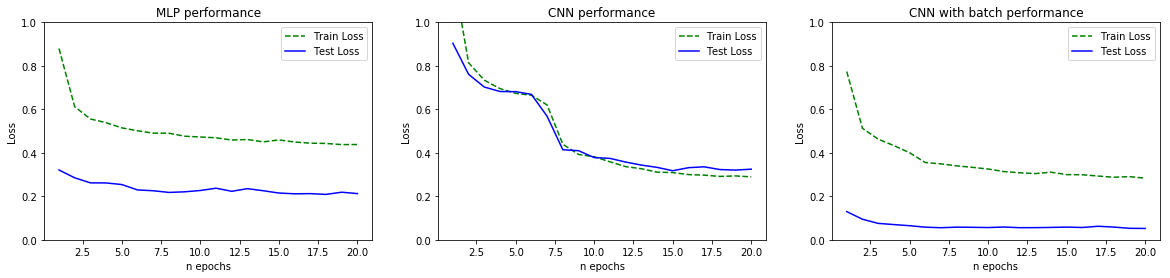

In [15]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 3, 1)
plot_metrics(ax, mlp_metrics, "MLP performance", n_epochs)
ax = fig.add_subplot(1, 3, 2)
plot_metrics(ax, cnn_metrics, "CNN performance", n_epochs)
ax = fig.add_subplot(1, 3, 3)
plot_metrics(ax, cnn_batch_metrics, "CNN with batch performance", n_epochs)

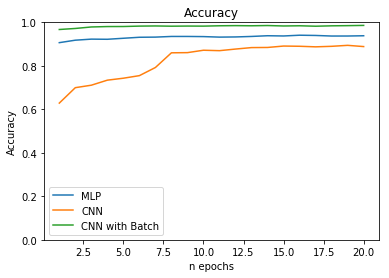

In [16]:
fig = plt.figure()
ax = plt.axes()
plot_accuracy(ax, [mlp_metrics, cnn_metrics, cnn_batch_metrics], ["MLP", "CNN", "CNN with Batch"], n_epochs)

### Images probably not complex and big enough for simple CNN to outperform MLP
### Batch_norm makes a massive difference

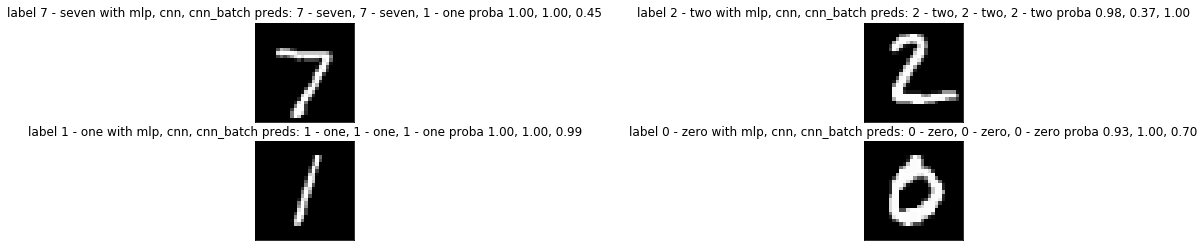

In [73]:
mlp.load_state_dict(torch.load("trained_models\mlp.pt"))
cnn.load_state_dict(torch.load("trained_models\cnn.pt"))
cnn_batch.load_state_dict(torch.load("trained_models\cnn_batch.pt"))

images, labels = next(iter(testloader))
reverse_dict = {b:a for a,b in testset.class_to_idx.items()}

preds_mlp = torch.exp(mlp(images))
top_p_mlp, top_class = preds_mlp.topk(1, dim=1)
preds_mlp = [reverse_dict[int(a.numpy())] for a in top_class]

preds_cnn = torch.exp(cnn(images))
top_p_cnn, top_class = preds_cnn.topk(1, dim=1)
preds_cnn = [reverse_dict[int(a.numpy())] for a in top_class]

preds_cnn_batch = torch.exp(cnn_batch(images))
top_p_cnn_batch, top_class = preds_cnn_batch.topk(1, dim=1)
preds_cnn_batch = [reverse_dict[int(a.numpy())] for a in top_class]

fig = plt.figure(figsize=(20, 4))
plot_size=4
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx][0].numpy()), cmap='gray')
    title = "label {} with mlp, cnn, cnn_batch preds: {}, {}, {} proba {:.2f}, {:.2f}, {:.2f}".format(
    reverse_dict[int(labels[idx])], preds_mlp[idx], preds_cnn[idx], preds_cnn_batch[idx],
    float(top_p_mlp[idx]), float(top_p_cnn[idx]), float(top_p_cnn_batch[idx])
    )
    plt.title(title) 